# On the risk of Flooding to accessibility to Stroke care centres in Vietnam

The project is a part of the World Bank's Disruptive Technology for Public Assets Governance (DT4PAG) supporting the Government of Vietnam. This work is done by Tuan Phan, Parvathy Krisnan, and Kai Kaiser from the World Bank.

For this blog, we will showcase the power of cloud base technology to help officials in the Vietnam's public sectors to cope with the new technology age. We use Google's Colab environment for data analytics and Google Drive as storage.

In [1]:
#@title
!pip install geopandas pandas raster2xyz flask requests 2>&1 >/dev/null
import warnings
warnings.filterwarnings("ignore")

In [2]:
#@title
from google.colab import drive
# To use this collab, please take note on how to mount the data drive
# 1. Add shortcut of the HSPI folder to your Main Drive by right-clicking
# at the folder name HSPI on the top -> Add shortcut to Drive -> Add to Main Drive
# Remember, you have to add the shortcut to your Main Drive folder
# 2. Run this cell. You will be asked to go to a Google's link.
# Follow its instructions and copy the OAuth2 string.
# Paste it to the text box in the result cell under this and press Enter
# Voila. It is mounted
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#@title
root_dir = './drive/MyDrive/Tuan_Analysis_Vietnam_Stroke/'
import sys
sys.path.append(root_dir)

# I. Aims of the Analysis
## 1. Stroke and other Cardiovascular diseases
According to the WHO, strokes are the third most common cause of death in the world after cancer and coronary heart disease. The number of strokes is expected to increase to 1.2 million cases by the year 2025. In Vietnam, strokes are the top most common cause of death and disability. In the past three years, the number of admitted patients has also sharply increased. It is estimated that 200,000 new cases are reported each year, 50% of which are fatal. Among the surviving patients, 90% faced severe after-effects such as cognitive disorders, loss of mobility, speaking or swallowing difficulties. With strokes, however, more so than with most other conditions, rapid diagnosis and timely care are absolutely critical for the success of the treatment. The narrow timeframe within which optimal treatment is possible is known as “the golden hour” - which is 60 mins - 1 hour. 
Based on a research study conducted at a major public hospital in Vietnam where there are approximately 15,000 hospital admissions for stroke per year, the median time from stroke onset to hospital arrival was 15.7 hours based on a sample of 6601 patients. 

## 2. Accessibility to Stroke care facilities

Stroke care facilities tend to be relatively dispersed, or limited to major urban centers.  Stroke victims have to be quickly channeled to appropriately qualified and equipped centers or their likelihood of death or permanent disabilities increases significantly.  The golden hour refers to the significant value of getting stroke victims to an appropriate diagnostic and treatment facility in time.
As the public sector in developed and developing country settings increasingly also look to mapping services, it is vital to be able to evaluate the pros and cons of different data sources and APIs in a practical manner against critical purposes.

This analysis will focus on how the risk layer of floods may affect the accessibility of the Vietnamese population to the critically needed stroke facilities across the country.


# II. Introduction to GeoPandas and Geospatial Toolkits

GeoPandas is a Python library aimed at providing a GIS-like toolkit for data scientist to use the power of map for big data analysis with other powerful Python data analytic libraries. Further use of GeoPandas can be accessed [here](https://towardsdatascience.com/visualising-global-population-datasets-with-python-c87bcfc8c6a6)

We can start using GeoPandas by loading a map of Vietnam with boundaries between different provinces.

GeoPandas supports the reading of *.geojson* file with different coordinating standards. For this one, we use WGS84. GeoPandas will return a GeoDataframe, same as Pandas's Dataframe but for geospatial coordinates and other related functions, for the user to plot and analyze.

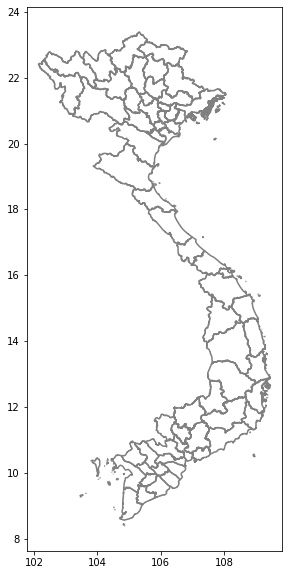

In [4]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt

vn_prov = gpd.read_file(root_dir + '/Data/gadm_vietnam.geojson')
vn_map = vn_prov.boundary.plot(figsize=(30,10), color='gray')

# III. Precipitation and Flood datasets


There are several publicly available datasets on weather predictions in map format. It is critical for government officials to understand the effects of the ever-changing environment, especially in the next decade, onto the country's infrastructures and the population. In this context of this blog, we will focus on two particular datasets and their effects on the population's accessibility to stroke care facilities:
* FATHOM2
* CHIRPS

## 1. FATHOM2 flood dataset

Fathom2 Global is the flood scenarios dataset developed by Bristol University’s Hydrological Research Group focusing on flood risk assessment on natural hazard management and insurance industry. The research methodology of Fathom2 production is described in the academic paper: Sampson, Christopher C., et al. "[A high‐resolution global flood hazard model.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015WR016954)" Water resources research 51.9 (2015): 7358-7381.  \\

Fathom2 global flood model uses 2 input datasets: MERIT-DEM - a global DEM and MERIT-Hydro - a global hydro network. Using the two-dimensional hydrodynamic model LISFLOOD-FP, Fathom2 simulates and provides flood scenarios for 10 return periods: from small flood with 1 in 5 years return period to bigger flood with 1 in 10; 20; 50; 75; 100; 200; 250, 500 to 1000 year return period for the whole world. 

Fathom2 includes two independent flood datasets for two factors causing floods: Fluvial (Upstream river flood) and Pluvial (Local rain) flood.  The coastal components such as tide and storm surge and sea level rise due to climate change are not considered. We will focus more on Fluvial data, both defended and undefended scenarios, as river floods risk is one of the most important environmental risk factors faced by the Government of Vietnam in the next decade.

Fathom2 data is in raster format as TIFF file with pixel size 90x90m. They can be opened directly in the common GIS software such as QGIS or ArcGIS. In Python, we can directly load the TIFF file or using raster2xyz to transform TIFF to csv data files.

Let's load an example file of Fluvial Defended scenario in the next 5 years.

In [5]:
import pandas as pd
fathom2_file = root_dir + "Data/vietnam/fluvial_defended/FD_1in5.csv"
fathom2_data = pd.read_csv(fathom2_file)
fathom2_data.dropna(inplace=True)
fathom2_data.columns = ['Lon', 'Lat', 'FD_5yrs_level']
fathom2_data.describe()

,Lon,Lat,FD_5yrs_level
count,3.742867e+06,3.742867e+06,3.742867e+06
mean,1.068656e+02,1.488037e+01,7.547060e+02
std,1.573846e+00,4.615944e+00,4.290550e+02
min,1.021692e+02,8.366667e+00,1.000023e-02
25%,1.056708e+02,1.041250e+01,9.990000e+02
50%,1.068033e+02,1.379167e+01,9.990000e+02
75%,1.080667e+02,2.007250e+01,9.990000e+02
max,1.095075e+02,2.316583e+01,9.990000e+02


There are 3.74 millions data point across the country. The longitude and latitude has the accuracy of 6 decimal points - the equivalence of 0.112 meters. The flood risk dataset has the format of:
*   $0$ : No data available
*   $(0, 999)$: flood depth (m)
*   $999$: Permanent water body

Looking at the dataframe description, we can see that leaving permanent water body would unnecessarily burden our computation as they contribute nothing to our analytics.
It is best to remove them and reform the dataframe before using:

In [ ]:
# remove permanent water body to reduce calculation time
fathom2_data = fathom2_data.where(fathom2_data['FD_5yrs_level'] < 999)
fathom2_data.dropna(inplace=True)
fathom2_data.reset_index(drop=True, inplace=True)
fathom2_data.describe()

,Lon,Lat,FD_5yrs_level
count,916337.000000,916337.000000,916337.000000
mean,106.288833,16.365596,1.157375
std,1.351861,4.764101,1.675659
min,102.169167,8.579167,0.010000
25%,105.440833,11.403333,0.128853
50%,105.892500,16.739167,0.481063
75%,107.431667,21.148333,1.478325
max,109.395000,23.165833,10.000000


FATHOM2 data points can be loaded into a GeoDataFrame using Shapely's Point as part of the dataframe's geometry. Each data point is represented as a coordinate pair under WGS84.

In [ ]:
map_data = fathom2_data.where(fathom2_data['FD_5yrs_level']!=0).dropna()
geometry = [Point(xy) for xy in zip(map_data.Lon, map_data.Lat)]
map_data = map_data.drop(['Lon', 'Lat'], axis=1)
gdf = GeoDataFrame(map_data, crs="EPSG:4326", geometry=geometry)

By using GeoPandas to draw an overlay of the flood risk, we can see the distribution of this risk layer across different parts of Vietnam. Here, we can see the flood risk in the next 5 years, assuming there are flood prevention mechanisms. The Northern region surrounding Hanoi, Thai Nguyen, and Yen Bai has the highest chance of flood with the Mekong Delta in 2nd place. These two regions are both big river deltas, facing severe risks from their rivers in the upcoming years.

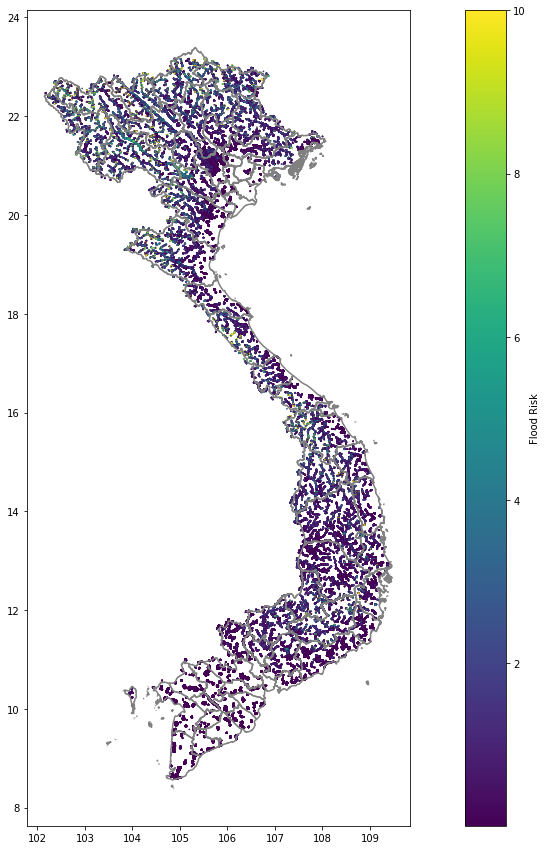

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
vn_map = vn_prov.boundary.plot(ax=ax, color='gray')
gdf.plot(ax=ax, markersize=0.5, column='FD_5yrs_level', legend=True,
         legend_kwds={'label': "Flood Risk"})

## 2. CHIRPS precipitation dataset

CHIRPS 2.0 dataset is created and maintained by the Climate Hazards Group,    Department of Geography, University of California at Santa Barbara, in collaboration with the USGS Famine Early Warning Systems Network (FEWS NET). The dataset is available publicly to download [here](https://data.chc.ucsb.edu/products/CHIRPS-2.0/). 

The dataset provides near-real time precipitation data across the world in quasi-global format. It is provided under multiple timeframes for the users to choose from. CHIRPS ver 2.0 has its data dated from 01-Jan-1981 to near-real time. It has daily, 5-day, 10-day, monthly, 2-month, 3-month, quarterly, and annual data on all of its stations around the world. The datasets provided to the public cover the entire world in quasi-global format (  50S−50N ). CHIRPS 2.0 also has more detailed data on several stations: Africa, East Africa, Mexico, Cameroon - Caribbean, and Indonesia.

CHIRPS 2.0 global dataset comes with a quasi-global map of 5 kilometer grid cell. The data can be downloaded directly from the research group’s [website](https://data.chc.ucsb.edu/products/CHIRPS-2.0/) in TIF format or from Google Earth Engine.

Further information on the methodology and other useful informations can be accessed [here](https://www.nature.com/articles/sdata201566)


In this instance, we use monthly CHIRPS data from Nov 2011 to Oct 2021. We extract TIF-format files into csv files for easier access by pandas and geopandas using raster2xyz library:

In [ ]:
from raster2xyz.raster2xyz import Raster2xyz
import os
rtxyz = Raster2xyz()
source_tif = root_dir + "/Data/CHIRPS/tif/"
save_dir = root_dir + "/Data/CHIRPS/Raw/"
file_names = os.listdir(save_dir)

tif_list = os.listdir(source_tif)
tif_list = [x for x in tif_list if os.path.isfile(source_tif+x) or (ext in x)]
csv_list = os.listdir(save_dir)
csv_list = [x for x in csv_list if os.path.isfile(save_dir+x) or (ext in x)]
file_names = list(set(tif_list) - set(csv_list))

for file_name in file_names:
    input_tif = tif_list + file_name + '.tif'
    out_csv = save_dir + file_name + '.csv'
    rtxyz.translate(input_tif, out_csv)

We collate these monthly datasets into one combined dataframe and save them for later use:

In [ ]:
import numpy as np
from tqdm import tqdm

file_dir = root_dir + "/Data/CHIRPS/Raw/"
file_names = os.listdir(file_dir)
chirps_df = pd.DataFrame()
for csv_file in tqdm(file_names):
    if '.csv' not in csv_file:
        continue
    new_df = pd.read_csv(file_dir + csv_file)
    year, month = csv_file.split('.')[2:4]
    new_df.columns = ['Lon', 'Lat', str(month)+'-'+str(year)]
    if chirps_df.shape[0] == 0:
        chirps_df = new_df
    else:
        chirps_df = chirps_df.merge(new_df,
                                    how='outer',
                                    on=['Lat', 'Lon'])
# chirps_df.to_csv(root_dir + "/Data/CHIRPS/chirps_full_data.csv", index=False)
chirps_df.iloc[:10, :5]

In [6]:
chirps_df = pd.read_csv(root_dir + "/Data/CHIRPS/chirps_full_data.csv")

KeyboardInterrupt: ignored

We now need to extract Vietnam data from the worldwide dataset. Using Geopandas's *contains()* functions across billions of points is very ineffective, so we can start by removing points that have coordinates outside the range of maximum/minimum longtitude and latitude of Vietnam's boundary using *geometry.unary_union* variable from GeoDataFrame. This would be quicker as SQL-like support on these calculations is fast :

In [ ]:
vn_bound = vn_prov.geometry.unary_union

min_lon, min_lat, max_lon, max_lat = vn_bound.bounds
chirps_df = chirps_df.where(chirps_df['Lon']<max_lon).dropna()
chirps_df = chirps_df.where(chirps_df['Lon']>min_lon).dropna()
chirps_df = chirps_df.where(chirps_df['Lat']<max_lat).dropna()
chirps_df = chirps_df.where(chirps_df['Lat']>min_lat).dropna()
chirps_df.reset_index(inplace=True, drop=True)

Now, we can use *contains()* to finally remove the remaining irrelevant points:

In [ ]:
from shapely.geometry import Point
vn_bound = vn_prov.geometry.unary_union

drop_list = []
for idx in range(chirps_df.shape[0]):
    new_lon = chirps_df["Lon"][idx]
    new_lat = chirps_df["Lat"][idx]
    cur_point = Point(new_lon, new_lat)
    if not vn_bound.contains(cur_point):
        drop_list.append(idx)
chirps_df.drop(drop_list, inplace=True)
# chirps_df.to_csv(root_dir + "/Data/CHIRPS/chirps_vn_data.csv", index=False)

In [7]:
chirps_df = pd.read_csv(root_dir + "/Data/CHIRPS/chirps_vn_data.csv")
chirps_df.describe()

,Lon,Lat,11-2011,12-2011,01-2012,02-2012,03-2012,04-2012,05-2012,06-2012,07-2012,08-2012,09-2012,10-2012,11-2012,12-2012,01-2013,02-2013,03-2013,04-2013,05-2013,06-2013,07-2013,08-2013,09-2013,10-2013,11-2013,12-2013,01-2014,02-2014,03-2014,04-2014,05-2014,06-2014,07-2014,08-2014,09-2014,10-2014,11-2014,12-2014,...,07-2018,08-2018,09-2018,10-2018,11-2018,12-2018,01-2019,02-2019,03-2019,04-2019,05-2019,06-2019,07-2019,08-2019,09-2019,10-2019,11-2019,12-2019,01-2020,02-2020,03-2020,04-2020,05-2020,06-2020,07-2020,08-2020,09-2020,10-2020,11-2020,12-2020,01-2021,02-2021,03-2021,04-2021,05-2021,06-2021,07-2021,08-2021,09-2021,10-2021
count,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,...,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000,11204.000000
mean,106.310728,16.644711,150.771371,51.345274,33.428554,31.779629,43.244721,149.643303,281.269249,211.841324,329.749183,310.143321,360.781962,162.972489,113.473737,29.971933,30.788575,25.671391,43.966644,90.474897,210.234776,222.248971,359.753835,347.311973,354.030817,198.041301,171.493137,29.778743,20.308327,18.795144,26.672204,94.840351,163.866497,225.972546,346.500120,343.837310,231.021594,187.613650,106.220299,60.871884,...,366.074228,345.759926,271.951060,161.954031,98.379243,80.478498,42.897382,23.220574,31.221277,68.037042,206.785780,180.850299,279.386635,307.503435,200.590871,199.554447,106.566007,24.096578,25.476727,24.921999,39.236281,110.303834,186.977694,159.316821,223.098261,341.614521,289.110758,423.674407,128.894754,60.488424,21.275148,36.984591,27.227598,140.271821,202.384184,195.933971,264.363544,256.446966,380.579354,391.846297
std,1.630049,4.616625,182.536638,72.771455,37.481143,20.216767,29.007795,126.489403,98.147839,91.517811,115.115433,136.483906,160.882703,107.182528,87.441138,31.205213,25.103291,13.581292,26.596163,34.547530,62.106520,67.100140,149.480148,107.397892,246.413932,148.438792,200.098892,30.225725,36.197067,13.454458,17.456829,44.343839,79.357751,85.587352,131.434142,125.475260,71.779179,160.664957,86.376663,78.200531,...,171.528691,144.065158,98.072182,74.725004,83.396493,80.717186,50.660803,17.810104,16.180602,31.394125,81.871854,97.253539,100.877981,106.570293,85.802905,116.756767,96.437483,37.430970,30.556827,20.383491,26.489353,58.205363,105.410957,93.843538,112.898095,132.236795,92.680662,387.786187,144.347806,69.956784,33.225281,30.289636,15.223772,65.203392,85.583559,66.127210,100.091484,113.296360,187.641028,281.681676
min,102.175004,8.424999,1.256836,0.786884,0.147140,0.415049,3.329123,23.608768,17.275055,25.068205,34.253700,37.291412,61.132774,17.003872,2.031184,0.295416,0.131513,0.933839,0.306650,15.036209,26.119950,44.315590,57.690662,46.443237,50.663640,15.530073,2.220933,0.292220,0.113335,0.251766,0.232119,10.252358,14.422642,15.366932,34.421180,54.575024,50.441210,8.240644,1.404522,1.143281,...,15.112677,18.801268,81.974920,12.216213,2.267559,0.725263,0.237747,0.379421,0.472758,3.015151,16.198460,8.984343,27.268911,40.427876,49.628410,31.142965,1.835023,0.387687,0.115029,0.425636,0.239649,5.543688,14.177645,5.686361,12.3

Using the October 2021 data, we can see the distribution of precipitation in one of the earliest, and coldest, winter in Vietnam in the last decade:

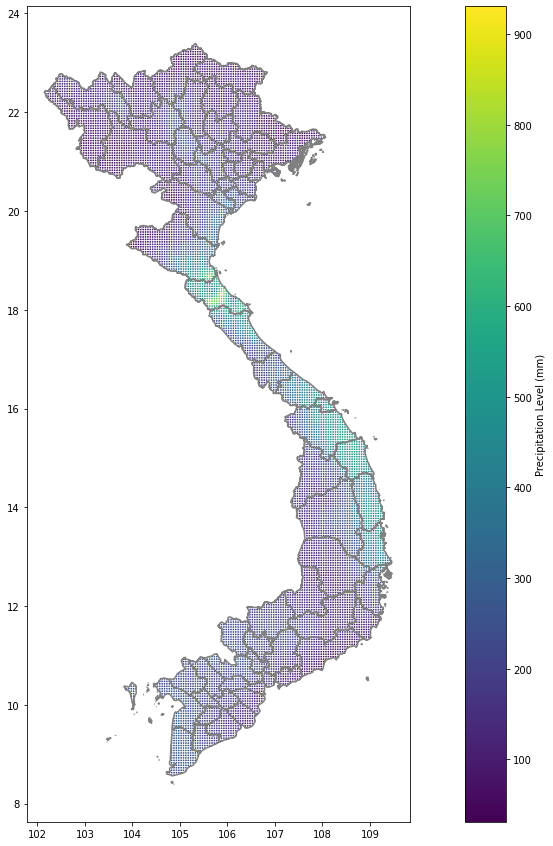

In [ ]:
map_data = chirps_df[['Lat', 'Lon', '10-2019']]
geometry = [Point(xy) for xy in zip(map_data.Lon, map_data.Lat)]
map_data = map_data.drop(['Lon', 'Lat'], axis=1)
gdf = GeoDataFrame(map_data, crs="EPSG:4326", geometry=geometry)
fig, ax = plt.subplots(figsize=(20,15))
vn_map = vn_prov.boundary.plot(ax=ax, color='gray')
gdf.plot(ax=ax, markersize=0.5, column='10-2019',
         legend=True,
         legend_kwds={'label': "Precipitation Level (mm)"})

# IV. Weather risk layers on Stroke accessibility


## 1. Dataset description

The stroke facility dataset is kept updated by the World Bank's specialists with support from the Ministry of Health of Vietnam. It comes with various descriptive information, but we will focus on these main ones:

* Facility_Name : English name of the stroke facility
* Lon : the longitude of the stroke facility
* Lat : the latitude of the stroke facility
* Province : the province's English name where the facility situated
* District : the district's English name where the facility situated

In [8]:
import pandas as pd
facs_file = root_dir + "/Data/stroke_facs_latest.csv"
stroke_data = pd.read_csv(facs_file)[['Name_English','longitude',
                                      'latitude','pro_name_e','dist_name_e']]
stroke_data.columns = ['Facility_Name','Lon','Lat','Province','District']

Since most facilities have their area in the scale of hundreds of squared meters, having 6 decimal level of accuracy is not beneficial for most analytical uses. Thus, we can round the coordinates to 3-decimal level for 100 meters level of accuracy.

In [9]:
stroke_data['Lon'] = stroke_data['Lon'].apply(lambda x: round(x, 3))
stroke_data['Lat'] = stroke_data['Lat'].apply(lambda x: round(x, 3))
stroke_data.head(5)

,Facility_Name,Lon,Lat,Province,District
0,Saint Paul Municipal General Hospital,105.836,21.032,Ha Noi,Ba Dinh District
1,Viet Duc (University) Hospital (CS1,105.845,21.030,Ha Noi,Hoan Kiem District
2,Hanoi Municipal Heart Hospital (CS1),105.844,21.024,Ha Noi,Hoan Kiem District
3,Duc Giang General Hospital,105.898,21.062,Ha Noi,Long Bien District
4,E Hospital,105.790,21.051,Ha Noi,Cau Giay District


## 2. Historical precipitation analysis

Strict comparison between two coordinate pairs is hard to apply en mass due to large area spanning over multiple coordinates. Moreover, using meters accuracy to understand weather layers is not practical because most weather events would affect an area on kilometers scale. To match the weather layer to facilities set, we have to find closest area of coordinates pairs from one source GPS point. 

With that in mind, we will draw a square with a size of $5*10^{-3} rad$ from each side of the GPS point of the facilities. The new under-effect area would have the size of $1km * 1 km$. Any weather risk points staying within this representative area would count towards the facilities. 

With the precipitation data, we will apply maximum as the aggregation function to show the intensity of the precipitation level in one region.

Let's make an example with CHIRPS's Oct 2021 data:

In [10]:
from copy import deepcopy
from tqdm import tqdm
import math
import numpy as np

oct_chirps_data = deepcopy(chirps_df[['Lon', 'Lat', '10-2021']])

sq_size = 5 # square area's radius
dec_level = 2   # decimal accuracy level

chirps_facs_df = deepcopy(stroke_data)
chirps_facs_df['10-2021'] = np.ones(chirps_facs_df.shape[0]) * np.nan
# round the facilities' coordinates accordingly
chirps_facs_df['Lon'] = chirps_facs_df['Lon'].apply(lambda x: round(x,
                                                                    dec_level))
chirps_facs_df['Lat'] = chirps_facs_df['Lat'].apply(lambda x: round(x,
                                                                    dec_level))

# iterate through all the facilities to find the corresponding point
for i in range(chirps_facs_df.shape[0]):
    current_facs = chirps_facs_df.iloc[i, :]
    facs_lon = current_facs["Lon"]
    facs_lat = current_facs["Lat"]

    # create the representative area's coordinates
    upper_lon = facs_lon + sq_size * math.pow(10, -dec_level)
    lower_lon = facs_lon - sq_size * math.pow(10, -dec_level)
    upper_lat = facs_lat + sq_size * math.pow(10, -dec_level)
    lower_lat = facs_lat - sq_size * math.pow(10, -dec_level)

    # queries the dataframe to find the flood risk points
    flood_df = oct_chirps_data.where(oct_chirps_data["Lon"] < upper_lon).dropna()
    flood_df = flood_df.where(flood_df["Lon"] > lower_lon).dropna()
    flood_df = flood_df.where(flood_df["Lat"] < upper_lat).dropna()
    flood_df = flood_df.where(flood_df["Lat"] > lower_lat).dropna()

    # this is to prevent the case of no suitable data points
    # breaking the function
    if flood_df.shape[0] == 0:
        continue
    prep_value = max(flood_df['10-2021'].to_numpy())
    chirps_facs_df.iloc[i, 5] = prep_value

After the merging, we can sort the dataframe to see which facility have the rainiest month compared to the rest:

In [ ]:
chirps_oct_df = chirps_facs_df.where(chirps_facs_df['10-2021'] != 0).dropna()
chirps_oct_df.sort_values('10-2021', ascending=False).reset_index(drop=True)

,Facility_Name,Lon,Lat,Province,District,10-2021
0,Dong Hoi Vietnam-Cuba Friendship Hospital,106.60,17.47,Quang Binh,Dong Hoi City,1294.39900
1,Quang Nam Central General Hospital,108.62,15.44,Quang Nam,Nui Thanh District,1241.70970
2,Hue Central Hospital,107.59,16.46,Thua Thien Hue,Hue City,1234.46000
3,Quang Nam Provincial General Hospital,108.48,15.57,Quang Nam,Tam Ky City,1212.55830
4,Quang Nam Northern Mountainous Regional Genera...,108.12,15.89,Quang Nam,Dai Loc District,1158.90090
...,...,...,...,...,...,...
101,Uong Bi Vietnam Sweden Hospital,106.75,21.04,Quang Ninh,Uong Bi City,188.37796
102,Quang Ninh Provincial General Hospital,107.09,20.95,Quang Ninh,Ha Long City,187.31711
103,Bac Giang Provincial General Hospital,106.20,21.27,Bac Giang,Bac Giang,179.99144
104,Lang Son Provincial General Hospital,106.76,21.88,Lang Son,Cao Loc District,151.12749


Dong Hoi Vietnam-Cuba Friendship Hospital has the highest rainfall level in October with over 1294 mm. This is mostly natural for the South Central Coast region as the rainy/stormy season is currently in place. Later positions further confirm this phenomenon as all the top five facilities are in this region with all of them having over 1150 mm in the month of October.

On the other hand, the last five positions are from the Northern region with Lao Cai bottom out the list with only 135.00476 mm in October. The winter of 2021 has come early, affecting the overall weather in the North with dry and cold winds.

Text(106.6, 17.47, 'Dong Hoi Vietnam-Cuba\n                 Friendship Hospital')

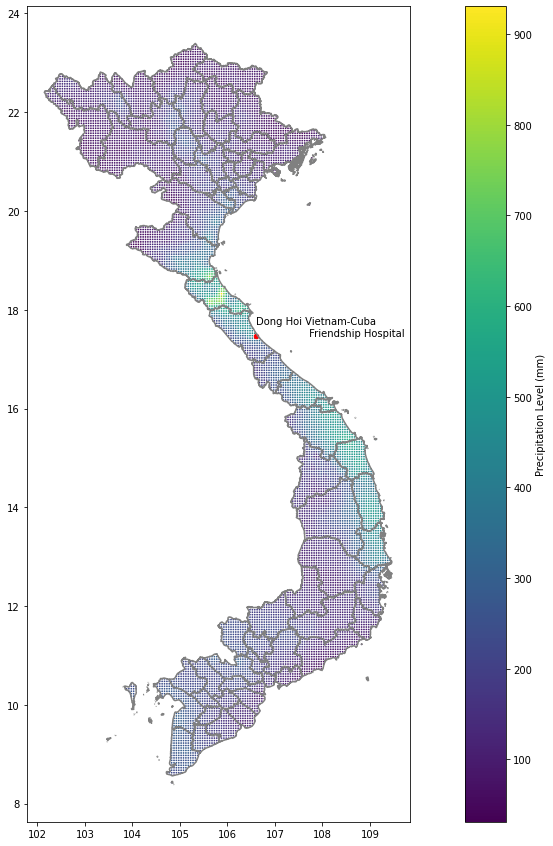

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
vn_map = vn_prov.boundary.plot(ax=ax, color='gray')
gdf.plot(ax=ax, markersize=0.5, column='10-2019',
         legend=True,
         legend_kwds={'label': "Precipitation Level (mm)"})
ax.scatter(106.60, 17.47, s=20, color='red')
ax.annotate("""Dong Hoi Vietnam-Cuba
                 Friendship Hospital""", (106.60, 17.47))

We collected Vietnam’s maximum rainfall values from all daily rainfall files available, from 01-01-1981 to 31-10-2021, from CHIRPS’s p05 directory. The collection lasted from 31 Nov 2021 to 05 Dec 2021.

In [11]:
from datetime import date, timedelta
chirps_daily_df = pd.read_csv(root_dir + 'Data/chirps_daily_vietnam.csv')
chirps_daily_df.columns = ['max_rain', 'timeframe']

yrs_list = [str(int(x)) for x in np.arange(1981, 2022, 1)]

sdate = date(2008, 1, 1)  # start date
edate = date(2008, 12, 31)  # end date

delta = edate - sdate  # as timedelta
date_list = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    date_list.append(str(day)[5:])
chirps_daily_df_new = pd.DataFrame()
for col in date_list:
    chirps_daily_df_new[col] = np.ones(len(yrs_list)) * np.nan

chirps_daily_df_new.index = yrs_list
for idx in tqdm(range(chirps_daily_df.shape[0])):
    mon_day = chirps_daily_df['timeframe'][idx][5:]
    yr = chirps_daily_df['timeframe'][idx][:4]
    chirps_daily_df_new[mon_day][yr] = chirps_daily_df['max_rain'][idx]

100%|██████████| 14914/14914 [00:01<00:00, 10235.53it/s]


As seen in the chart, the rainfall values have extreme right tails across the entire yearly calendar. These outliers are usually the results of La Nina’s effect on the Central Coastal region of Vietnam. The mean values usually rise as we progress from spring towards summer and peak at the end September, the stormy season in Vietnam. These values slowly decrease as winter approaches, signalling the usual dry and cold winter in the North and Central regions and the dry season in the South.

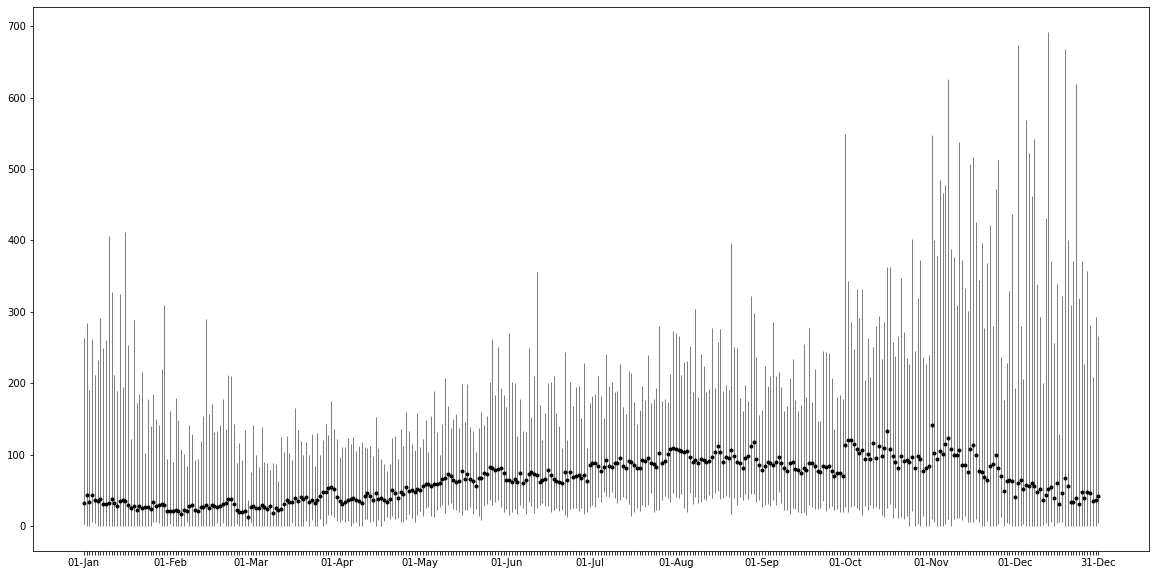

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_daily_chirps = chirps_daily_df_new.mean(axis=0)
max_daily_chirps = chirps_daily_df_new.max(axis=0)
min_daily_chirps = chirps_daily_df_new.min(axis=0)
show_labels = ['01-Jan']+['']*30+['01-Feb']+['']*28+['01-Mar']+['']*30+['01-Apr']+['']*29+['01-May']+['']*30+['01-Jun']+['']*29+['01-Jul']+['']*30+['01-Aug']+['']*30+['01-Sep']+['']*29+['01-Oct']+['']*30+['01-Nov']+['']*29+['01-Dec']+['']*29+['31-Dec']
ax.set_xticklabels(show_labels)
temp_plt = ax.errorbar(chirps_daily_df_new.columns,
                       mean_daily_chirps,
                       [mean_daily_chirps - min_daily_chirps,
                        max_daily_chirps - mean_daily_chirps],
                       fmt='.k', ecolor='gray', lw=1)

To further confirm the narrative, we load up the daily data of October 2021 to see if the monthly reading is representative across the month or there might be some peculiar event happened during the month. We extracted the daily data for Dong Hoi Vietnam - Cuba Friendship Hospital, and plotted its daily values against the country’s median daily precipitation:

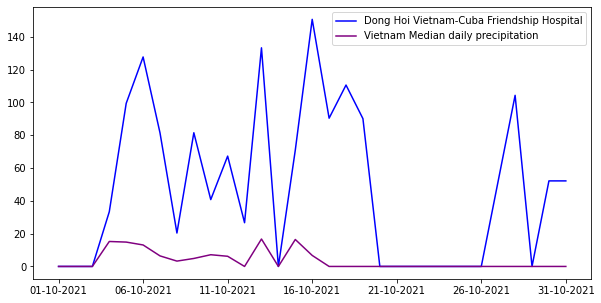

In [ ]:
oct_chirps_daily = pd.read_csv(root_dir + "/Data/CHIRPS/chirps_vn_data_daily.csv")

facs_lon = 106.60
facs_lat = 17.47

# create the representative area's coordinates
upper_lon = facs_lon + sq_size * math.pow(10, -dec_level)
lower_lon = facs_lon - sq_size * math.pow(10, -dec_level)
upper_lat = facs_lat + sq_size * math.pow(10, -dec_level)
lower_lat = facs_lat - sq_size * math.pow(10, -dec_level)

# queries the dataframe to find the flood risk points
qn_daily = oct_chirps_daily.where(oct_chirps_daily["Lon"] < upper_lon).dropna()
qn_daily = qn_daily.where(qn_daily["Lon"] > lower_lon).dropna()
qn_daily = qn_daily.where(qn_daily["Lat"] < upper_lat).dropna()
qn_daily = qn_daily.where(qn_daily["Lat"] > lower_lat).dropna()
qn_daily.reset_index(drop=True, inplace=True)

qn_daily_max = qn_daily.max(axis=0).iloc[2:]
fig, ax = plt.subplots(figsize=(10,5))
qn_daily_max.plot(ax=ax, color='blue')

vn_daily_median = oct_chirps_daily.median(axis=0).iloc[2:]
vn_daily_median.plot(ax=ax, color='purple')
ax.legend(['Dong Hoi Vietnam-Cuba Friendship Hospital',
           'Vietnam Median daily precipitation'])
fig.show()

We can see the daily trend of precipitation in and around Dong Hoi Vietnam - Cuba Friendship Hospital confirms its monthly reading. Its daily precipitation levels are much higher than the rest of the country's.

In [ ]:
chirps_daily_donghoi = pd.read_csv(root_dir + 'Data/chirps_daily_donghoi.csv')
chirps_daily_donghoi.columns = ['sq1', 'sq2', 'sq3', 'sq4','timeframe']

yrs_list = [str(int(x)) for x in np.arange(1981, 2022, 1)]

sdate = date(2008, 10, 1)  # start date
edate = date(2008, 10, 31)  # end date

delta = edate - sdate  # as timedelta
date_list = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    date_list.append(str(day)[5:])
chirps_daily_donghoi_new = pd.DataFrame()
for col in date_list:
    chirps_daily_donghoi_new[col] = np.ones(len(yrs_list)) * np.nan

chirps_daily_donghoi_new.index = yrs_list
for idx in tqdm(range(chirps_daily_donghoi.shape[0])):
    mon_day = chirps_daily_donghoi['timeframe'][idx][5:]
    yr = chirps_daily_donghoi['timeframe'][idx][:4]
    chirps_daily_donghoi_new[mon_day][yr] = max(chirps_daily_donghoi.iloc[idx, :4])

As we look closer to our rainiest stroke facility in Oct 2021, Dong Hoi Vietnam-Cuba Friendship Hospital, we can see similar patterns when we extract the daily rainfall data of its surrounding areas for the month of October from 1981 to 2021 from CHIRPS. For most years, there is not much rain. Usually, the daily rain levels are close to 0 in the month of October with small rains here and there across the month. 

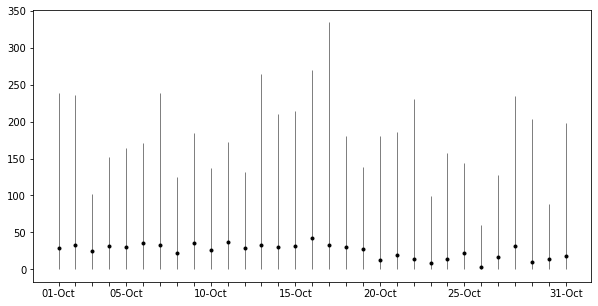

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
mean_daily_chirps = chirps_daily_donghoi_new.mean(axis=0)
max_daily_chirps = chirps_daily_donghoi_new.max(axis=0)
min_daily_chirps = chirps_daily_donghoi_new.min(axis=0)
show_labels = ['01-Oct']+['']*3+['05-Oct']+['']*4+['10-Oct']+['']*4+['15-Oct']+['']*4+['20-Oct']+['']*4+['25-Oct']+['']*5+['31-Oct']
ax.set_xticklabels(show_labels)
temp_plt = ax.errorbar(chirps_daily_donghoi_new.columns,
                       mean_daily_chirps,
                       [mean_daily_chirps - min_daily_chirps,
                        max_daily_chirps - mean_daily_chirps],
                       fmt='.k', ecolor='gray', lw=1)

However, looking at the yearly scale, one can see how La Nina creates extreme levels of rain throughout the historical view. High levels of rainfall coincide with La Nina occurrence: 1983 (1,085.16 mm), 1988 (1,273.45 mm), 1989 (998.72 mm), 1999 (906.69 mm), 2007 (1,208.37 mm), 2008 (1,182.09 mm), 2010 (1,364.92 mm), 2016 (1,264.72 mm), 2020 (1,522.44 mm), and 2021 (1,484.43 mm). Thus, the occurrence in October 2021 as we have seen in Figure 6 is not particularly an outlier, but rather an effect from a global-scale phenomenon. 

In [ ]:
chirps_daily_donghoi_new.sum(axis=1).plot(figsize=(10,5),ylabel='Cumulative rainfall (mm)')

1981     803.17141
1982     998.30090
1983    1085.16400
1984     806.11509
1985     757.27830
1986     983.96380
1987     309.83450
1988    1273.44790
1989     998.72320
1990    1011.22470
1991    1383.44060
1992     634.71212
1993     467.19690
1994     334.61950
1995     666.03100
1996     315.18400
1997     604.86380
1998     307.36230
1999     906.68700
2000     747.75280
2001     677.13820
2002     480.37920
2003     356.91200
2004     305.89660
2005     721.10120
2006     674.36100
2007    1208.36890
2008    1182.09490
2009     505.44720
2010    1364.91890
2011     940.34270
2012     509.45780
2013     692.27650
2014     516.87234
2015     671.54600
2016    1264.72110
2017     757.04580
2018     318.26430
2019     569.38200
2020    1522.43915
2021    1484.43460
dtype: float64

In [ ]:
number_of_bins = 10

labels = chirps_daily_donghoi_new.columns
data_sets = chirps_daily_donghoi_new.to_numpy()

# Computed quantities to aid plotting
hist_range = (np.min(data_sets), np.max(data_sets))
binned_data_sets = [
    np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    for d in data_sets
]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, sum(binned_maximums), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
centers = 0.5 * (bin_edges + np.roll(bin_edges, 1))[:-1]
heights = np.diff(bin_edges)

# Cycle through and plot each histogram
fig, ax = plt.subplots()
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - 0.5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)

ax.set_xticks(x_locations, labels)

ax.set_ylabel("Data values")
ax.set_xlabel("Data sets")

plt.show()

## 3. Fluvial flood risk and Stroke accesibility

### 3.1. Mapping Stroke facilities to the Flood risk layer

As used in the previous sector, we can apply the same narrative with the FATHOM2's data.

We would now modularize the code and testing en mass across the 20 Fluvial scenario datasets:

In [ ]:
# List all flood dataset
file_dict = {'FD_5yrs_level': "Data/vietnam/fluvial_defended/FD_1in5.csv",
            'FD_10yrs_level': "Data/vietnam/fluvial_defended/FD_1in10.csv",
            'FD_20yrs_level': "Data/vietnam/fluvial_defended/FD_1in20.csv",
            'FD_50yrs_level': "Data/vietnam/fluvial_defended/FD_1in50.csv",
            'FD_75yrs_level': "Data/vietnam/fluvial_defended/FD_1in75.csv",
            'FD_100yrs_level': "Data/vietnam/fluvial_defended/FD_1in100.csv",
            'FD_200yrs_level': "Data/vietnam/fluvial_defended/FD_1in200.csv",
            'FD_250yrs_level': "Data/vietnam/fluvial_defended/FD_1in250.csv",
            'FD_500yrs_level': "Data/vietnam/fluvial_defended/FD_1in500.csv",
            'FD_1000yrs_level': "Data/vietnam/fluvial_defended/FD_1in1000.csv",
            'FU_5yrs_level': "Data/vietnam/fluvial_undefended/FU_1in5.csv",
            'FU_10yrs_level': "Data/vietnam/fluvial_undefended/FU_1in10.csv",
            'FU_20yrs_level': "Data/vietnam/fluvial_undefended/FU_1in20.csv",
            'FU_50yrs_level': "Data/vietnam/fluvial_undefended/FU_1in50.csv",
            'FU_75yrs_level': "Data/vietnam/fluvial_undefended/FU_1in75.csv",
            'FU_100yrs_level': "Data/vietnam/fluvial_undefended/FU_1in100.csv",
            'FU_200yrs_level': "Data/vietnam/fluvial_undefended/FU_1in200.csv",
            'FU_250yrs_level': "Data/vietnam/fluvial_undefended/FU_1in250.csv",
            'FU_500yrs_level': "Data/vietnam/fluvial_undefended/FU_1in500.csv",
            'FU_1000yrs_level': "Data/vietnam/fluvial_undefended/FU_1in1000.csv",
            }
all_flood_cases = list(file_dict.keys())

In [ ]:
def find_closest_points(flood_df_full, flood_scenario, facs_df, aggregate_func,
                        sq_size=5, dec_level=3):
    new_facs_df = deepcopy(facs_df)
    # round them accordingly
    new_facs_df['Lon'] = new_facs_df['Lon'].apply(
        lambda x: round(x, dec_level))
    new_facs_df['Lat'] = new_facs_df['Lat'].apply(
        lambda x: round(x, dec_level))
    new_facs_df[flood_scenario] = np.ones(new_facs_df.shape[0], dtype=float) * np.nan
    # iterate through all the facilities to find the corresponding point
    for idx in range(new_facs_df.shape[0]):
        current_facs_df = new_facs_df.iloc[idx, :]
        facs_longitude = current_facs_df["Lon"]
        facs_latitude = current_facs_df["Lat"]

        upper_longitude = facs_longitude + sq_size * math.pow(10, -dec_level)
        lower_longitude = facs_longitude - sq_size * math.pow(10, -dec_level)
        upper_latitude = facs_latitude + sq_size * math.pow(10, -dec_level)
        lower_latitude = facs_latitude - sq_size * math.pow(10, -dec_level)

        # queries the dataframe to find the flood risk points
        new_flood_df = flood_df_full.where(
            flood_df_full["Lon"] < upper_longitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lon"] > lower_longitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lat"] < upper_latitude).dropna()
        new_flood_df = new_flood_df.where(
            new_flood_df["Lat"] > lower_latitude).dropna()
        
        # this is to prevent the case of no suitable data points
        # breaking the function
        if new_flood_df.shape[0] == 0:
            continue

        new_facs_df.iloc[idx, 5] = aggregate_func(
            new_flood_df[flood_scenario].to_numpy())
    return new_facs_df[flood_scenario].to_numpy()

We compile the analytical code for our previous example into a function to extract information from the remaining list of dataset from FATHOM2

Then, we insert new columns for the remaining datasets into the combined dataframe for spatial and temporal analysis later. This will save time as our scope of analysis span across all datasets.

In [ ]:
round_facs_df = deepcopy(stroke_data)
for flood_case in tqdm(list(file_dict.keys())):
    file_data = pd.read_csv(root_dir + file_dict[flood_case])
    file_data.columns = ['Lon', 'Lat', flood_case]
    file_data = file_data.where(file_data[flood_case] < 999)
    file_data.dropna(inplace=True)
    file_data.reset_index(drop=True, inplace=True)
    round_facs_df[flood_case] = find_closest_points(file_data, flood_case,
                                                    stroke_data, max)

round_facs_df.to_csv(root_dir + 'Data/full_facs_flood.csv', index=False)

100%|██████████| 20/20 [16:14<00:00, 48.72s/it]


We can see the temporal evolution of flood risk across the top 5 index facilities in Hanoi. As the time move on, in both defended and undefended scenarios, the potential flood depth increases. Moreover, generally speaking, facilities face higher potential flood depth in undefended scenarios than in defended one in the same time period.

Facilities in the worst quartile of having flood in the next 5 years with no flood defense mechanism are still mostly in the Red River Delta around the upstream of the Red River in the mountainous areas in the Northwestern region, with the exception of Ninh Thuan in the South:

In [ ]:
round_facs_df = pd.read_csv(root_dir + 'Data/full_facs_flood.csv')
time_frames = ['5 years', '10 years', '20 years', '50 years',
                 '75 years', '100 years', '200 years', '250 years',
                 '500 years', '1000 years']

In [ ]:
max_fas_df = deepcopy(round_facs_df)
max_fas_df.loc[round_facs_df.shape[0]] = round_facs_df.max(axis=0)

fd_max_list = []
fu_max_list = []
for flood_case in max_fas_df.columns:
    if 'FD' in flood_case:
        fd_max_list.append(max_fas_df[flood_case][max_fas_df.shape[0]-1])
    if 'FU' in flood_case:
        fu_max_list.append(max_fas_df[flood_case][max_fas_df.shape[0]-1])

flood_max = pd.DataFrame({'Flood Defended (m)': fd_max_list,
                          'Flood Undefended (m)': fu_max_list})
flood_max.index = time_frames

flood_max

,Flood Defended (m),Flood Undefended (m)
5 years,8.580994,8.50808
10 years,10.000000,10.00000
20 years,10.000000,10.00000
50 years,10.000000,10.00000
75 years,10.000000,10.00000
100 years,10.000000,10.00000
200 years,10.000000,10.00000
250 years,10.000000,10.00000
500 years,10.000000,10.00000
1000 years,10.000000,10.00000


### 3.2. Spatial Risk Analysis

Using the combined spatial risk layers dataset, we can now start analyze the flood risk across Vietnam.

First off, we need to transform the original dataframe with rows showing the potential flood depth for each facilities into the name of facilities with its cardinal ranking equal to its index, sorted descendingly.

In [ ]:
# sort descendingly the facilities by the flood chance in each category
# Let the user see directly the sorted tables without changing code

max_count = 0
by_facs_dict = dict()
by_prov_dict = dict()
max_count_prov = 0
# extracting the sorted list of facilities
for flood_case in all_flood_cases:
    temp_df = round_facs_df.sort_values(flood_case, ascending=False)
    temp_df = temp_df.where(temp_df[flood_case] > 0)
    temp_df.dropna(inplace=True)
    facs_list = temp_df["Facility_Name"].to_numpy().tolist()
    by_facs_dict[flood_case] = facs_list
    # keep the maximum list length for dataframe formation. See below
    if len(facs_list) > max_count:
        max_count = len(facs_list)
    
    # showing the effect on each province
    temp_df = temp_df[['Province', flood_case]]
    aggregation_functions = {flood_case: 'count'}
    temp_df = temp_df.groupby(['Province']).aggregate(aggregation_functions)
    temp_df.reset_index(inplace=True)
    by_prov_dict[flood_case] = temp_df
    # keep the maximum list length for dataframe formation. See below
    if temp_df.shape[0] > max_count_prov:
        max_count_prov = temp_df.shape[0]

for flood_case in all_flood_cases:
    curr_len = len(by_facs_dict[flood_case])
    # as each flood case has different length list
    # one has to make them conform to the maximum length list
    # in order to form a dataframe
    if curr_len < max_count:
        # this is a hack as I tried using numpy ndarray to no avail
        # will try to make things more elegant when I have more time
        for i in range(max_count - curr_len):
            by_facs_dict[flood_case].append('None')


In the next 100 years, almost all of the top 5 most affected facilities, with the exception of Can Tho Municipal General Hospital, are from the upstream area of the Red River's river network in North Vietnam. This echoes the problems faced by the Government of Vietnam for a long period of time: flash floods and river floods in the mountainous Northwest. 

In [ ]:
# Top 5 most affected facilities
by_facs_df = pd.DataFrame.from_dict(by_facs_dict)
by_facs_df.iloc[:5, :6]

,FD_5yrs_level,FD_10yrs_level,FD_20yrs_level,FD_50yrs_level,FD_75yrs_level,FD_100yrs_level
0,Lao Cai Provincial General Hospital (merged La...,Lao Cai Provincial General Hospital (merged La...,Lao Cai Provincial General Hospital (merged La...,Hoa Binh Provincial General Hospital,Hoa Binh Provincial General Hospital,Hoa Binh Provincial General Hospital
1,Vinh Phuc Provincial General Hospital,Hoa Binh Provincial General Hospital,Hoa Binh Provincial General Hospital,Lao Cai Provincial General Hospital (merged La...,Lao Cai Provincial General Hospital (merged La...,Lao Cai Provincial General Hospital (merged La...
2,105 Military Hospital,Vinh Phuc Provincial General Hospital,Vinh Phuc Provincial General Hospital,Vinh Phuc Provincial General Hospital,Vinh Phuc Provincial General Hospital,Vinh Phuc Provincial General Hospital
3,Phuc Yen Regional General Hospital,105 Military Hospital,An Giang Cardiology Hospital,An Giang Cardiology Hospital,Phuc Yen Regional General Hospital,Phuc Yen Regional General Hospital
4,Can Tho Municipal General Hospital,Phuc Yen Regional General Hospital,105 Military Hospital,Phuc Yen Regional General Hospital,An Giang Cardiology Hospital,105 Military Hospital


We can also collate the original dataset showing risk values into categorical values by the provinces of the facilities to see which provinces would face the most risk in the future. This would allow better insight on funds distribution and master planning to Health official as relocation of facilities and improvement of flood defense take time and great cost.

In [ ]:
# collate the provincial facilities affected data into one df
by_prov_df = by_prov_dict[all_flood_cases[0]]
for i in range(1, len(all_flood_cases)):
    temp_df = by_prov_dict[all_flood_cases[i]]
    by_prov_df = by_prov_df.merge(temp_df, on='Province', how='outer')

Even though the mountainous area has the worst affected facilities, provinces in the Mekong Delta have more supposedly flooded facilities compared to the Northern ones. This paradox can be explained that the facilities in the mountainous Northwestern usually face moderate to major floods, yet, scattered across a large area. However, in the South, especially in Can Tho and Ho Chi Minh City, the area, most of the time, faces minor flooding across a large swathe of low-level land, thus, resulting in more number of affected facilities but with much lower risk levels.

In [ ]:
by_prov_df.sort_values('FD_50yrs_level',
                       ascending=False)[['Province', 'FD_50yrs_level']].head(5)

,Province,FD_50yrs_level
0,Can Tho,4.0
5,Ho Chi Minh City,4.0
1,Ha Noi,4.0
12,Vinh Long,2.0
11,Thái Nguyên,2.0


We can repeat the process of transforming the value dataframe into a cardinal ranking one to see which provinces have more affected facilities for budgeting and planning purposes. This is the top 10 provinces with most affected facilities in the next 100 years, assuming flood defense mechanism exists:

In [ ]:
# doing the same for the provincial list
by_prov_sorted_dict = dict()
for flood_case in all_flood_cases:
    # as each flood case has different length list
    # one has to make them conform to the maximum length list
    # in order to form a dataframe
    curr_len = by_prov_dict[flood_case].shape[0]
    temp_df = by_prov_dict[flood_case].sort_values(flood_case, ascending=False)
    # temp_df.reset_index(inplace=True)
    curr_prov_list = temp_df['Province'].to_numpy().tolist()
    if curr_len < max_count_prov:
        # this is a hack as I tried using numpy ndarray to no avail
        # will try to make things more elegant when I have more time
        for i in range(max_count_prov - curr_len):
            curr_prov_list.append('None')
    by_prov_sorted_dict[flood_case] = curr_prov_list
by_prov_sorted_df = pd.DataFrame.from_dict(by_prov_sorted_dict)
# Top 10 affected provinces in next 100 years 
by_prov_sorted_df.iloc[:10, :6]

,FD_5yrs_level,FD_10yrs_level,FD_20yrs_level,FD_50yrs_level,FD_75yrs_level,FD_100yrs_level
0,Ha Noi,Ha Noi,Can Tho,Can Tho,Ho Chi Minh City,Ha Noi
1,Vinh Phuc,Can Tho,Ha Noi,Ha Noi,Can Tho,Ho Chi Minh City
2,Can Tho,Vinh Phuc,Vinh Long,Ho Chi Minh City,Ha Noi,Can Tho
3,Lao Cai,An Giang,Vinh Phuc,An Giang,An Giang,An Giang
4,None,Ho Chi Minh City,An Giang,Vinh Long,Quang Nam,Quang Nam
5,None,Hoa Binh,Ho Chi Minh City,Thái Nguyên,Vinh Long,Vinh Long
6,None,Lao Cai,Hoa Binh,Thanh Hoa,Thái Nguyên,Thái Nguyên
7,None,Phu Tho,Lao Cai,Quang Nam,Thanh Hoa,Thanh Hoa
8,None,Thua Thien Hue,Phu Tho,Vinh Phuc,Vinh Phuc,Vinh Phuc
9,None,None,Quang Nam,Nam Dinh,Lao Cai,Lao Cai


### 3.3. Temporal Analysis

Finally, we can compare the difference between the two scenario groups across the time: defended vs. undefended. The result shows that, in the next 100 years, spending on flood defense would allow better accessibility for the people of Vietnam as undefended scenarios usually affect more than double the number of facilities disturbed by floods in defended ones.

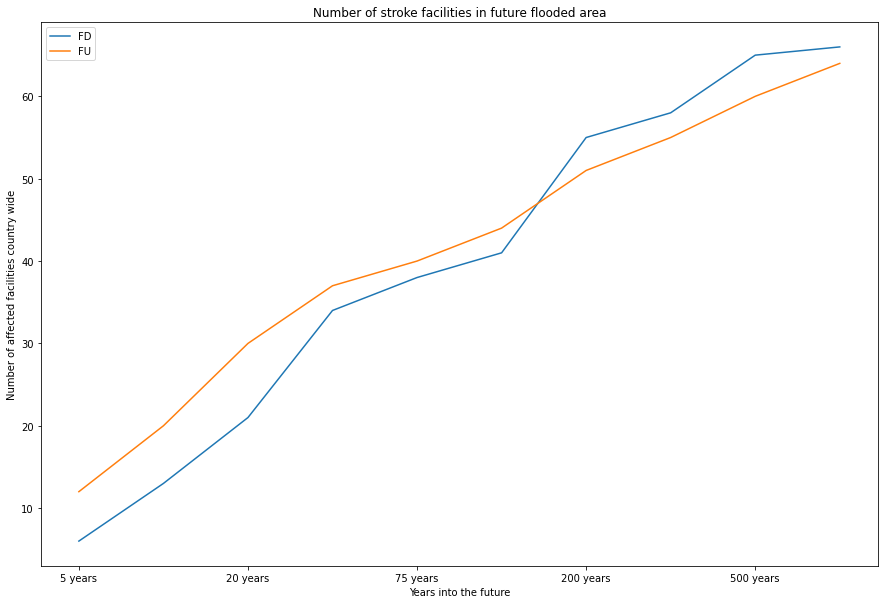

In [ ]:
# count the number of affected facilities in each group of flood cases: defended vs. undefended
fd_affected_count = []
fu_affected_count = []
p_affected_count = []
for flood_case in all_flood_cases:
    affected_facs = round_facs_df[round_facs_df[flood_case] != 0].shape[0]
    if 'FD' in flood_case:
        fd_affected_count.append(affected_facs)
    elif 'FU' in flood_case:
        fu_affected_count.append(affected_facs)

# reform the data for presentation
affected_df = pd.DataFrame({'FD': fd_affected_count,
                            'FU': fu_affected_count})
affected_df.index=['5 years', '10 years', '20 years', '50 years', '75 years',
                   '100 years', '200 years', '250 years',
                   '500 years', '1000 years', ]
affected_df.plot.line(title='Number of stroke facilities in future flooded area',
                      figsize=(15, 10),
                      xlabel='Years into the future',
                      ylabel='Number of affected facilities country wide')

The more the time pass, the more facilities in different regions, especially in the next 5 to 10 years, with the growth rates of the number of affected facilities are $50\% - 117\%$.

In [ ]:
fd_growth = np.ones(len(affected_df['FD'])) * np.nan
fu_growth = np.ones(len(affected_df['FU'])) * np.nan
for time in range(1, len(affected_df['FU'])):
    fd_growth[time] = ((affected_df['FD'][time] - affected_df['FD'][time - 1]) /
                       affected_df['FD'][time - 1] * 100)
    fu_growth[time] = ((affected_df['FU'][time] - affected_df['FU'][time - 1]) /
                       affected_df['FU'][time - 1] * 100)
affected_df['FD_growth (%)'] = fd_growth
affected_df['FU_growth (%)'] = fu_growth
affected_df

,FD,FU,FD_growth (%),FU_growth (%)
5 years,6,12,NaN,NaN
10 years,13,20,116.666667,66.666667
20 years,21,30,61.538462,50.000000
50 years,34,37,61.904762,23.333333
75 years,38,40,11.764706,8.108108
100 years,41,44,7.894737,10.000000
200 years,55,51,34.146341,15.909091
250 years,58,55,5.454545,7.843137
500 years,65,60,12.068966,9.090909
1000 years,66,64,1.538462,6.666667


## 4. Pluvial flood risk and Historical precipitation

Unlike Fluvial flood risks, Pluvial flood risks across Vietnam are not that  critical. The maximum values are much smaller. Thus, it is more reasonable to detach them from the rest of FATHOM2. 

However, pluvial floods still pose tangible risks to health care accessibility. We would use FATHOM2's Pluvial along with CHIRPS data to show the correlation between historical precipitation and future potential hinderance to stroke care access.

Pluvial data is large to handle in Colab environment so we analyzed behind the scene and saved to a file to present here.

In [ ]:
# Adding Pluvial scenarios
round_facs_df = pd.read_csv(root_dir + 'Data/full_data_analytic.csv')
pluvial_facs_df = round_facs_df[['Facility_Name', 'Lon','Lat', "Province",
                                    'P_5yrs_level', 'P_10yrs_level',
                                    'P_20yrs_level', 'P_50yrs_level', 
                                    'P_75yrs_level', 'P_100yrs_level',
                                    'P_200yrs_level', 'P_250yrs_level', 
                                    'P_500yrs_level', 'P_1000yrs_level']]

In [ ]:
pluvial_facs_df.sort_values('P_5yrs_level', ascending=False).head(10)

,Facility_Name,Lon,Lat,Province,P_5yrs_level,P_10yrs_level,P_20yrs_level,P_50yrs_level,P_75yrs_level,P_100yrs_level,P_200yrs_level,P_250yrs_level,P_500yrs_level,P_1000yrs_level
14,Lao Cai Provincial General Hospital (merged La...,104.032,22.437,Lao Cai,5.095383,5.095383,5.095383,5.095383,5.095383,5.095383,5.095383,5.095383,5.095383,10.000000
51,Tay Nguyen Regional General Hospital (formerly...,108.055,12.665,Dak Lak,2.658417,2.658417,2.658417,2.658417,2.658417,2.658417,2.658417,2.658417,2.658417,3.671356
60,Ba Ria Provincial General Hospital,107.197,10.510,Ba Ria - Vung Tau,0.396564,0.396564,0.396564,0.396564,0.396564,0.396564,0.396564,0.396564,0.396564,2.208488
16,Hoa Binh Provincial General Hospital,105.354,20.827,Hoa Binh,0.355692,0.355692,0.355692,0.355692,0.355692,0.355692,0.355692,0.355692,0.355692,5.912352
86,Xuyen A General Hospital (BVXA-HCMC),106.558,10.927,Ho Chi Minh City,0.264357,0.264357,0.264357,0.264357,0.264357,0.264357,0.264357,0.264357,0.264357,1.260983
93,Xuyen A General Hospital (BVXA)-Vinh Long,105.941,10.261,Vinh Long,0.237453,0.237453,0.237453,0.237453,0.237453,0.237453,0.237453,0.237453,0.237453,0.413398
96,An Giang Cardiology Hospital,105.439,10.389,An Giang,0.179586,0.179586,0.179586,0.179586,0.179586,0.179586,0.179586,0.179586,0.179586,1.302823
19,Lang Son Provincial General Hospital,106.758,21.881,Lang Son,0.162056,0.162056,0.162056,0.162056,0.162056,0.162056,0.162056,0.162056,0.162056,2.790436
20,Quang Ninh Provincial General Hospital,107.087,20.953,Quang Ninh,0.054571,0.054571,0.054571,0.054571,0.054571,0.054571,0.054571,0.054571,0.054571,2.253902
73,Le Van Thinh General Hospital (formerly Distri...,106.768,10.782,Ho Chi Minh City,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.002147


For illustration, we will focus on the most affected facility: Lao Cai Provincial General Hospital. It is in the Northwestern region, which is notorious for flash floods for many years. The Pluvial data proves even further for the province's problem of flash flood that with precipitation alone, there can be flood with 5 meters depth, much higher than many fluvial floods.

First off, we extract the median value of monthly precipitation from 2011-2021 of all regions in Vietnam. The reason we take median, not mean, is because Vietnam has a diverse group of climate across the country: the North has distinct four seasons, while the South has only two. This causes a huge range of precipitation values in each month. Using mean would skew the data towards the region groups which has more data points, which is not representative.

In [ ]:
# take the median value
median_chirps = chirps_df.median(axis=0)[3:]
chirps_vn_df_monthly = pd.DataFrame()
for i in range(2011, 2022):
    chirps_vn_df_monthly[i] = np.ones(12) * np.nan
chirps_vn_df_monthly.index = np.arange(1, 13, dtype=int)
chirps_vn_df_monthly = chirps_vn_df_monthly.transpose()
for time_fr in median_chirps.index:
    month, year = [int(x) for x in time_fr.split('-')]
    chirps_vn_df_monthly[month][year] = median_chirps[time_fr]

mean_monthly_prep = chirps_vn_df_monthly.mean(axis=0)
mean_monthly_prep

1      19.851380
2      23.350094
3      32.974273
4      83.776236
5     206.009798
6     202.499847
7     300.319195
8     325.918188
9     279.254684
10    206.598246
11     95.258931
12     35.489765
dtype: float64

We extract the precipitation points related to the Lao Cai General Hospital. For this time, since the CHIRPS dataset is much less detailed compared FATHOM2's, we increase the square radius, to 10 rad, and the decimal level to 2.

In [ ]:
sq_size = 5
dec_level = 2

facs_lon = 104.032
facs_lat = 22.437

# create the representative area's coordinates
upper_lon = facs_lon + sq_size * math.pow(10, -dec_level)
lower_lon = facs_lon - sq_size * math.pow(10, -dec_level)
upper_lat = facs_lat + sq_size * math.pow(10, -dec_level)
lower_lat = facs_lat - sq_size * math.pow(10, -dec_level)

# queries the dataframe to find the flood risk points
prep_df = chirps_df.where(chirps_df["Lon"] < upper_lon).dropna()
prep_df = prep_df.where(prep_df["Lon"] > lower_lon).dropna()
prep_df = prep_df.where(prep_df["Lat"] < upper_lat).dropna()
prep_df = prep_df.where(prep_df["Lat"] > lower_lat).dropna()
prep_df = prep_df.reset_index(drop=True)

After we have extracted the CHIRPS data for the interested facility, we do the same as with the country data by taking the median values of monthly data. Moreover, we also take the maximum and minimum monthly values as well. Plotting an errorbar chart of the local data against the national median one would show why Lao Cai General Hospital,potentially,faces such a high risk of Pluvial flood.

In [ ]:
median_chirps_laocai = prep_df.median(axis=0)[3:]
chirps_lc_df_monthly = pd.DataFrame()
for i in range(2011, 2022):
    chirps_lc_df_monthly[i] = np.ones(12) * np.nan
chirps_lc_df_monthly.index = np.arange(1, 13, dtype=int)
chirps_lc_df_monthly = chirps_lc_df_monthly.transpose()

for time_fr in median_chirps_laocai.index:
    month, year = [int(x) for x in time_fr.split('-')]
    chirps_lc_df_monthly[month][year] = median_chirps_laocai[time_fr]

mean_monthly_prep_lc = chirps_lc_df_monthly.mean(axis=0)
min_monthly_prep_lc = chirps_lc_df_monthly.min(axis=0)
max_monthly_prep_lc = chirps_lc_df_monthly.max(axis=0)
pd.DataFrame({'Mean': mean_monthly_prep_lc,
              'Min': min_monthly_prep_lc,
              'Max': max_monthly_prep_lc})

,Mean,Min,Max
1,34.406531,16.581562,58.057095
2,38.350036,19.936380,72.875532
3,57.060903,32.121589,98.733155
4,115.370373,64.341405,210.605045
5,196.427124,110.176334,271.031495
6,194.355919,126.705415,288.315905
7,329.911479,226.683655,396.970370
8,366.713314,252.074620,496.268845
9,249.226187,164.492185,338.649225
10,118.290242,45.529674,199.082205


We can plot both the matplotlib's errorbar along with line chart using the *subplots()* functionality.

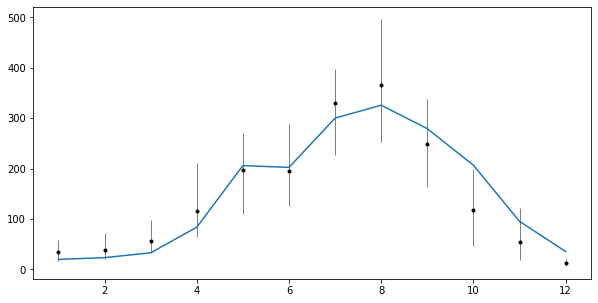

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

temp_plt = ax.errorbar(mean_monthly_prep_lc.index,
                        mean_monthly_prep_lc,
                        [mean_monthly_prep_lc - min_monthly_prep_lc,
                         max_monthly_prep_lc - mean_monthly_prep_lc],
                        fmt='.k', ecolor='gray', lw=1)
mean_monthly_prep.plot(ax=ax)

By looking at the chart, we can see that, during the summer, the area face much higher rain compared to the rest of country, especially in July. And these values are consistent across 10 years as the whiskers, both up and down, can rarely be seen in the three month of June, July, and August. For the rest of the year, Lao Cai General Hospital also has to face generally more rain in Spring, and less in late Autumn and Winter.

With this insight, one can venture to guess that the Pluvial data, although cannot tell when the floods may happen, can help the provincial official to see that they need to provide extra support and facilitation to potential stroke patients in late Spring and Summer. Propaganda programs can also focus these seasons to alarm the people the hinderance, which may come from the flood, in accessing critical stroke care in Lao Cai Province.

## 5. The affected population

Different facilities provide services to different population groups. By adding another layer, the population layer, we can assess how the flood risk change the accessibility of people across Vietnam and which groups should be aided more based on vulnerabilities and regions.


### Introduction to Facebook’s Population dataset

Facebook provides an free-to-access World's population dataset by using the latest technology in Computer Vision. By capturing the Spatial Image of households in every parts of the world, Facebook's technology can approximate the area's population with real-time update and decent accuracy. More about the dataset and its methodology can be read [here](https://dataforgood.facebook.com/dfg/tools/high-resolution-population-density-maps)

In [ ]:
# extract FB's population data
pop_file = root_dir + '/Data/population_vnm_2018-10-01(Facebook).csv'
fb_pop_data = pd.read_csv(pop_file)
fb_pop_data.columns = ['Lat', 'Lon','Pop_2015','Pop_2020']
fb_pop_data.head(10)

,Lat,Lon,Pop_2015,Pop_2020
0,8.564583,104.832361,7.462457,7.582185
1,8.567083,104.840417,7.462457,7.582185
2,8.567083,104.840694,7.462457,7.582185
3,8.567361,104.840694,7.462457,7.582185
4,8.568194,104.840417,7.462457,7.582185
5,8.568194,104.842361,7.462457,7.582185
6,8.568472,104.842639,7.462457,7.582185
7,8.569028,104.840972,7.462457,7.582185
8,8.570417,104.842083,7.462457,7.582185
9,8.570694,104.842083,7.462457,7.582185


### Analysis

We integrate the population dataset into the flood risk layer with summation of poulation point inside the $1km*1km$ square, instead of maximum value. We understand that merging population points using the previous *find_closest_points* function would allow some population points to be count towards multiple facilities, especially in the urban area where many facilities stay close to each other. However, matching the two dataset of billions of data points with closest distance would still require subjective threshold, and, more importantly, the computation cost is too much. We believe that these duplication would not skew the final results too much because most data points hold less than 100 people. Still, we acknowledge that the analytics would be more accurate if we have a dataset showing the size of the population served by each facilities. This is one of the higher aim for DT4PAG: help the public sector use more highly advanced technologies.

We will focus more on the 2020 Population values:

In [ ]:
flood_facs_w_pop = deepcopy(round_facs_df)
flood_facs_w_pop['Pop_2020'] = find_closest_points(fb_pop_data, 'Pop_2020',
                                                   stroke_data, sum)
flood_facs_w_pop.to_csv(root_dir + 'Data/full_df_w_pop.csv', index=False)
flood_facs_w_pop[['Facility_Name', 'Pop_2020']][:5]

,Facility_Name,Pop_2020
0,Saint Paul Municipal General Hospital,50509.031556
1,Viet Duc (University) Hospital (CS1,59913.218043
2,Hanoi Municipal Heart Hospital (CS1),61245.970836
3,Duc Giang General Hospital,8898.371100
4,E Hospital,16425.920172


**Spatial Analysis**

Applying the previous code on collating and transforming onto this population dataframe, we can come up with similar spatial and temporal analyses on the number of population affected by flood in different provinces and times.

In [ ]:
# sort descendingly the facilities by the flood chance in each category
# Let the user see directly the sorted tables without changing code

pop_by_prov_dict = dict()
max_count_prov = 0
# extracting the sorted list of facilities
for flood_case in all_flood_cases:
    # showing the effect on each province
    temp_df = deepcopy(flood_facs_w_pop[['Province', flood_case, 'Pop_2020']])
    temp_df.dropna(inplace=True)
    temp_df = temp_df.where(temp_df[flood_case] > 0)
    temp_df.dropna(inplace=True)
    
    aggregation_functions = {'Pop_2020': 'sum',
                             flood_case: 'max'}
    temp_df = temp_df.groupby(['Province']).aggregate(aggregation_functions)
    temp_df.drop([flood_case], axis=1, inplace=True)
    temp_df.reset_index(inplace=True)
    # rename the population column into the flood case for later collation
    temp_df.columns = ['Province', flood_case]
    pop_by_prov_dict[flood_case] = temp_df
    # keep the maximum list length for dataframe formation. See below
    if temp_df.shape[0] > max_count_prov:
        max_count_prov = temp_df.shape[0]

# collate the provincial facilities affected data into one df
pop_by_prov_df = pop_by_prov_dict[all_flood_cases[0]]
for i in range(1, len(all_flood_cases)):
    temp_df = pop_by_prov_dict[all_flood_cases[i]]
    pop_by_prov_df = pop_by_prov_df.merge(temp_df,
                                          on='Province',
                                          how='outer')

We also transform the above dataframe into a cardinal ranking list one to see which provinces are affected the most:

In [ ]:
# doing the same for the provincial list
pop_by_prov_sorted_dict = dict()
for flood_case in all_flood_cases:
    # as each flood case has different length list
    # one has to make them conform to the maximum length list
    # in order to form a dataframe
    curr_len = pop_by_prov_dict[flood_case].shape[0]
    temp_df = pop_by_prov_dict[flood_case].sort_values(flood_case,
                                                       ascending=False)
    # temp_df.reset_index(inplace=True)
    curr_prov_list = temp_df['Province'].to_numpy().tolist()
    if curr_len < max_count_prov:
        # this is a hack as I tried using numpy ndarray to no avail
        # will try to make things more elegant when I have more time
        for i in range(max_count_prov - curr_len):
            curr_prov_list.append('None')
    pop_by_prov_sorted_dict[flood_case] = curr_prov_list

pop_by_prov_sorted_df = pd.DataFrame.from_dict(pop_by_prov_sorted_dict)
# Top 10 affected provinces in next 100 years 
pop_by_prov_sorted_df.fillna(0).iloc[:5, :10]

,FD_5yrs_level,FD_10yrs_level,FD_20yrs_level,FD_50yrs_level,FD_75yrs_level,FD_100yrs_level,FD_200yrs_level,FD_250yrs_level,FD_500yrs_level,FD_1000yrs_level
0,Can Tho,Ha Noi,Ha Noi,Ho Chi Minh City,Ho Chi Minh City,Ha Noi,Ha Noi,Ha Noi,Ha Noi,Ha Noi
1,Ha Noi,Can Tho,Can Tho,Ha Noi,Ha Noi,Ho Chi Minh City,Ho Chi Minh City,Ho Chi Minh City,Ho Chi Minh City,Ho Chi Minh City
2,Vinh Phuc,Ho Chi Minh City,Ho Chi Minh City,Can Tho,Can Tho,Can Tho,Can Tho,Can Tho,Can Tho,Can Tho
3,Lao Cai,Vinh Phuc,Vinh Long,Thái Nguyên,An Giang,An Giang,An Giang,An Giang,An Giang,An Giang
4,None,An Giang,Vinh Phuc,An Giang,Thái Nguyên,Thái Nguyên,Thái Nguyên,Thái Nguyên,Thái Nguyên,Thái Nguyên


In the example of flood defended scenario group, it is apparent that the Mekong Delta, even though facing less severe floods, encompasses a much bigger population affected by reduced accessibility to stroke centres. It is of great importance that the potential patients must reach the stroke facilities in the golden hour before worse may happen. Flooding in this low-level land area proves to be costly for many people in the next century to come.

**Temporal Analysis**

By plotting the data with regards to the evolution of time, we can see how floods could cause a profound effect to the Vietnamese population by preventing them from receiving their stroke care on time:

In [ ]:
fd_pop_affected_count = []
fu_pop_affected_count = []
for flood_case in all_flood_cases:
    temp_df = flood_facs_w_pop.sort_values(flood_case, ascending=False)
    affected_pop = sum(temp_df.loc[temp_df[flood_case].dropna().index]['Pop_2020'].to_numpy())
    # print(flood_case+":   "+ str(affected_pop))
    if 'FD' in flood_case:
        fd_pop_affected_count.append(affected_pop)
    elif 'FU' in flood_case:
        fu_pop_affected_count.append(affected_pop)

# form data for presentation
affected_pop_df = pd.DataFrame({'FD': np.divide(fd_pop_affected_count, 1000),
                                'FU': np.divide(fu_pop_affected_count, 1000)})
affected_pop_df.index=['5 years', '10 years', '20 years', '50 years',
                       '75 years', '100 years', '200 years', '250 years',
                       '500 years', '1000 years']
affected_pop_df.plot.bar(title='Population within stroke facilities affect by flood in the future',
                          figsize=(15, 10), xlabel='Years into the future',
                          ylabel='Number of affected Pop in 2020 (in thousand)')

It is expected by the next 100 years that almost 500 thousands Vietnamese would not get their stroke care in time because flooding impedes their access to the closest stroke care facilities. As time move on, more and more people cannot receive their care in time, which, in turn, causes strain onto the health care system even more as these "late" patients with delicate complications require much more costly care compared to other diseases' complications.

In [ ]:
fd_growth = np.ones(len(affected_pop_df['FD'])) * np.nan
fu_growth = np.ones(len(affected_pop_df['FU'])) * np.nan
for time in range(1, len(affected_pop_df['FU'])):
    fd_growth[time] = ((affected_pop_df['FD'][time] - affected_pop_df['FD'][
        time - 1]) / affected_pop_df['FD'][time - 1] * 100)
    fu_growth[time] = ((affected_pop_df['FU'][time] - affected_pop_df['FU'][
        time - 1]) / affected_pop_df['FU'][time - 1] * 100)
affected_pop_df['FD_growth (%)'] = fd_growth
affected_pop_df['FU_growth (%)'] = fu_growth
affected_pop_df

,FD,FU,FD_growth (%),FU_growth (%)
5 years,38.868069,60.549577,NaN,NaN
10 years,109.596392,166.113235,181.970251,174.342519
20 years,157.650602,246.741191,43.846525,48.537948
50 years,274.714420,315.234414,74.255231,27.759136
75 years,297.110322,334.874145,8.152430,6.230199
100 years,413.851588,396.989689,39.292228,18.548922
200 years,904.923110,664.488257,118.658847,67.381742
250 years,971.955058,781.567017,7.407474,17.619387
500 years,1120.521462,819.711171,15.285316,4.880471
1000 years,1126.821079,947.132984,0.562204,15.544721


**Flood defense necessity**

It would be necessary for provincial officials information on how to balance the implementation of flood defense mechanisms and their incurred costs. 

With that in mind, we can divide the prepared dataframe above into 3 groups across all time frames.

In [ ]:
temp_df = pop_by_prov_df['FD_5yrs_level']
temp_df.dropna(how='all', inplace=True)
print('Affected Population count for FD_5yrs:', sum(temp_df.to_numpy()))

temp_df = pop_by_prov_df['FU_5yrs_level']
temp_df.dropna(how='all', inplace=True)
print('Affected Population count for FU_5yrs:', sum(temp_df.to_numpy()))

Affected Population count for FD_5yrs: 38868.06922037236
Affected Population count for FU_5yrs: 60549.577145889205


Comparing between the two flood scenarios, both in the next 5 years, it is clear that flood defense provides tremendous benefit both to the government and the people with respect to the accessibility to stroke care facilities. Flood undefended scenarios overwhelm its brother with almost doubled the population

In [ ]:
affected_pop_df['Difference (FU-FD)'] = np.subtract(affected_pop_df['FU'],
                                                    affected_pop_df['FD'])
affected_pop_df[['FD', 'FU', 'Difference (FU-FD)']]

,FD,FU,Difference (FU-FD)
5 years,2255.852798,2255.852798,-4.547474e-13
10 years,2255.852798,2255.852798,-4.547474e-13
20 years,2255.852798,2255.852798,0.000000e+00
50 years,2255.852798,2255.852798,4.547474e-13
75 years,2255.852798,2255.852798,4.547474e-13
100 years,2255.852798,2255.852798,4.547474e-13
200 years,2255.852798,2255.852798,0.000000e+00
250 years,2255.852798,2255.852798,0.000000e+00
500 years,2255.852798,2255.852798,4.547474e-13
1000 years,2255.852798,2255.852798,0.000000e+00


We can see that in the next century, flood defense mechanisms provide invaluable benefit for the population as these mechanisms allow tens of thousands Vietnamese to live the rest of their lives without the complications of stroke, which most of the time will cause direct and permanent damage to the brains. By preventing a group of population turns maimed and unfit for labors, which will cause future economic damage, the Government of Vietnam can increase its budget and planning to take into accounts the change of environment situation to reduce the effect of flood risks to the population

## 6. Flood Hazard levels

In [ ]:
H1 = 0.3
H2 = 0.5
H3 = 1.2
H4 = 2.0
H5 = 4.0

fd_stacked_dict = {'H1': np.zeros(len(time_frames), dtype=int),
                   'H2': np.zeros(len(time_frames), dtype=int),
                   'H3': np.zeros(len(time_frames), dtype=int),
                   'H4': np.zeros(len(time_frames), dtype=int),
                   'H5': np.zeros(len(time_frames), dtype=int),
                   'H6': np.zeros(len(time_frames), dtype=int)}

fu_stacked_dict = {'H1': np.zeros(len(time_frames), dtype=int),
                   'H2': np.zeros(len(time_frames), dtype=int),
                   'H3': np.zeros(len(time_frames), dtype=int),
                   'H4': np.zeros(len(time_frames), dtype=int),
                   'H5': np.zeros(len(time_frames), dtype=int),
                   'H6': np.zeros(len(time_frames), dtype=int)}

for flood_case in all_flood_cases:
    flood_case_list = flood_case.split('_')
    time_frame = flood_case_list[1][:-3] + ' years'
    time_idx = time_frames.index(time_frame)
    curr_flood_list = round_facs_df[flood_case].dropna().to_numpy()
    if 'FD' in flood_case:
        res_dict = fd_stacked_dict
    else:
        res_dict = fu_stacked_dict
    res_dict['H1'][time_idx] = np.count_nonzero(np.where(curr_flood_list <= H1))
    res_dict['H2'][time_idx] = np.count_nonzero(np.where((curr_flood_list > H1) & (curr_flood_list <= H2)))
    res_dict['H3'][time_idx] = np.count_nonzero(np.where((curr_flood_list > H2) & (curr_flood_list <= H3)))
    res_dict['H4'][time_idx] = np.count_nonzero(np.where((curr_flood_list > H3) & (curr_flood_list <= H4)))
    res_dict['H5'][time_idx] = np.count_nonzero(np.where((curr_flood_list > H4) & (curr_flood_list <= H5)))
    res_dict['H6'][time_idx] = np.count_nonzero(np.where(curr_flood_list > H5))

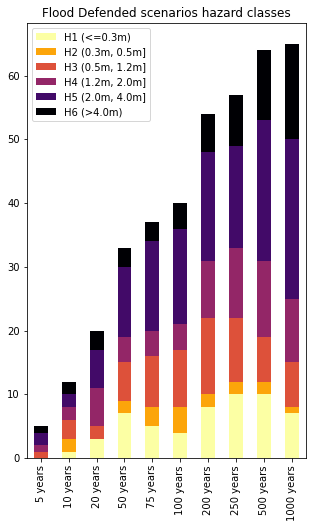

In [ ]:
fd_stacked_df = pd.DataFrame(fd_stacked_dict)
fd_stacked_df.columns = ['H1 (<=0.3m)','H2 (0.3m, 0.5m]',
                         'H3 (0.5m, 1.2m]', 'H4 (1.2m, 2.0m]',
                         'H5 (2.0m, 4.0m]', 'H6 (>4.0m)']
fd_stacked_df.index = time_frames
fd_stacked_df.plot.bar(stacked=True, cmap='inferno_r',
                       figsize=[5, 8],
                       title='Flood Defended scenarios hazard classes')

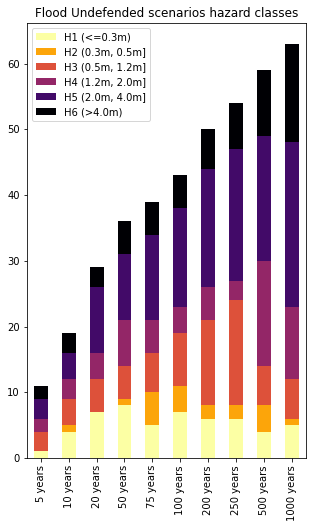

In [ ]:
fu_stacked_df = pd.DataFrame(fu_stacked_dict)
fu_stacked_df.columns = ['H1 (<=0.3m)','H2 (0.3m, 0.5m]',
                         'H3 (0.5m, 1.2m]', 'H4 (1.2m, 2.0m]',
                         'H5 (2.0m, 4.0m]', 'H6 (>4.0m)']
fu_stacked_df.index = time_frames
fu_stacked_df.plot.bar(stacked=True, cmap='inferno_r',
                       figsize=[5, 8],
                       title='Flood Undefended scenarios hazard classes')

In [ ]:
fd_pop_stacked_dict = {'H1': np.zeros(len(time_frames), dtype=int),
                   'H2': np.zeros(len(time_frames), dtype=int),
                   'H3': np.zeros(len(time_frames), dtype=int),
                   'H4': np.zeros(len(time_frames), dtype=int),
                   'H5': np.zeros(len(time_frames), dtype=int),
                   'H6': np.zeros(len(time_frames), dtype=int)}

fu_pop_stacked_dict = {'H1': np.zeros(len(time_frames), dtype=int),
                   'H2': np.zeros(len(time_frames), dtype=int),
                   'H3': np.zeros(len(time_frames), dtype=int),
                   'H4': np.zeros(len(time_frames), dtype=int),
                   'H5': np.zeros(len(time_frames), dtype=int),
                   'H6': np.zeros(len(time_frames), dtype=int)}

for flood_case in all_flood_cases:
    flood_case_list = flood_case.split('_')
    time_frame = flood_case_list[1][:-3] + ' years'
    time_idx = time_frames.index(time_frame)
    curr_flood_list = flood_facs_w_pop[flood_case].dropna().to_numpy()
    if 'FD' in flood_case:
        res_dict = fd_pop_stacked_dict
    else:
        res_dict = fu_pop_stacked_dict
    res_dict['H1'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where(curr_flood_list <= H1)])
    res_dict['H2'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where((curr_flood_list > H1) & (curr_flood_list <= H2))])
    res_dict['H3'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where((curr_flood_list > H2) & (curr_flood_list <= H3))])
    res_dict['H4'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where((curr_flood_list > H3) & (curr_flood_list <= H4))])
    res_dict['H5'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where((curr_flood_list > H4) & (curr_flood_list <= H5))])
    res_dict['H6'][time_idx] = sum(flood_facs_w_pop['Pop_2020'].loc[np.where(curr_flood_list > H5)])

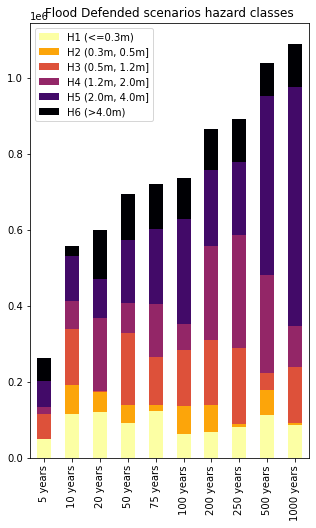

In [ ]:
fd_pop_stacked_df = pd.DataFrame(fd_pop_stacked_dict)
fd_pop_stacked_df.columns = ['H1 (<=0.3m)','H2 (0.3m, 0.5m]',
                         'H3 (0.5m, 1.2m]', 'H4 (1.2m, 2.0m]',
                         'H5 (2.0m, 4.0m]', 'H6 (>4.0m)']
fd_pop_stacked_df.index = time_frames
fd_pop_stacked_df.plot.bar(stacked=True, cmap='inferno_r',
                       figsize=[5, 8],
                       title='Flood Defended scenarios hazard classes')

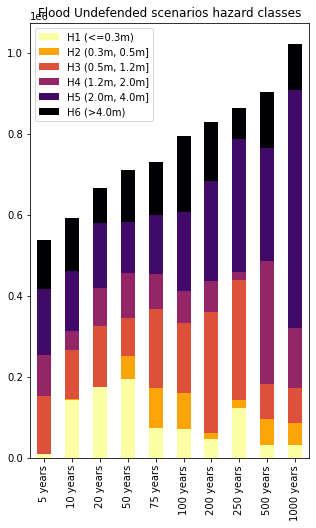

In [ ]:
fu_pop_stacked_df = pd.DataFrame(fu_pop_stacked_dict)
fu_pop_stacked_df.columns = ['H1 (<=0.3m)','H2 (0.3m, 0.5m]',
                         'H3 (0.5m, 1.2m]', 'H4 (1.2m, 2.0m]',
                         'H5 (2.0m, 4.0m]', 'H6 (>4.0m)']
fu_pop_stacked_df.index = time_frames
fu_pop_stacked_df.plot.bar(stacked=True, cmap='inferno_r',
                       figsize=[5, 8],
                       title='Flood Undefended scenarios hazard classes')

# V. Maintainence of the local storage of public datasets

Users with limited technical knowledge can use these functions to semi-automatically update their public dataset (e.g., CHIRPS)

In [ ]:
from bs4 import BeautifulSoup
import requests

def listFD(url, ext=''):
    page = requests.get(url).text
    # print page
    soup = BeautifulSoup(page, 'html.parser')
    return [node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

In [ ]:
url = 'https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/'
ext = '.gz'

for file in listFD(url, ext)[:10]:
    print(file)

chirps-v2.0.1981.01.tif.gz
chirps-v2.0.1981.02.tif.gz
chirps-v2.0.1981.03.tif.gz
chirps-v2.0.1981.04.tif.gz
chirps-v2.0.1981.05.tif.gz
chirps-v2.0.1981.06.tif.gz
chirps-v2.0.1981.07.tif.gz
chirps-v2.0.1981.08.tif.gz
chirps-v2.0.1981.09.tif.gz
chirps-v2.0.1981.10.tif.gz


In [ ]:
import os
def check_missing_tar(tar_dir, url, ext):
    tar_list = os.listdir(tar_dir)
    tar_list = [x for x in tar_list if os.path.isfile(tar_dir+x) or (ext in x)]
    url_files = listFD(url, ext)
    diff = list(set(url_files) - set(tar_list))
    return diff

tar_folder = root_dir + 'Data/CHIRPS/tar/'
print(check_missing_tar(tar_folder, url, ext))

[]


In [ ]:
import requests
import time
from tqdm import tqdm

def download_missing_files(tar_dir, save_dir, url, ext):
    file_list = check_missing_tar(tar_dir, url, ext)
    for file in tqdm(file_list):
        download_url = url + file
        file_dir = save_dir + file
        with open(file_dir, 'wb') as out_file:
            content = requests.get(download_url, stream=True).content
            out_file.write(content)
        time.sleep(1)
    return

In [ ]:
download_missing_files(tar_folder, tar_folder, url, ext)

0it [00:00, ?it/s]


And then unzip and check with tif file list

In [ ]:
import gzip
import shutil

def check_missing_tif(tar_dir, tif_dir):
    tar_list = os.listdir(tar_dir)
    tar_list = [x[:-7] for x in tar_list if os.path.isfile(tar_dir+x) or '.gz' in x]
    tif_list = os.listdir(tif_dir)
    tif_list = [x[:-4] for x in tif_list if os.path.isfile(tif_dir+x) or '.tif' in x]
    diff = list(set(tar_list) - set(tif_list))
    return diff

def unzip_missing_files(tar_dir, save_dir):
    file_list = check_missing_tif(tar_dir, save_dir)
    for file in tqdm(file_list):
        tif_file = save_dir + file + '.tif'
        tar_file = tar_dir + file + '.tif.gz'
        with gzip.open(tar_file, 'rb') as f_in:
            with open(tif_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    return

In [ ]:
tif_folder = root_dir + 'Data/CHIRPS/tif/'
unzip_missing_files(tar_folder, tif_folder)

100%|██████████| 120/120 [06:40<00:00,  3.34s/it]


In [ ]:
def check_missing_csv(tif_dir, csv_dir):
    tif_list = os.listdir(tif_dir)
    tif_list = [x[:-4] for x in tif_list if
                os.path.isfile(tif_dir + x) or '.tif' in x]
    csv_list = os.listdir(csv_dir)
    csv_list = [x[:-4] for x in csv_list if
                os.path.isfile(csv_dir + x) or '.csv' in x]
    diff = list(set(tif_list) - set(csv_list))
    return diff


def rasterize(tif_dir, save_dir):
    rtxyz = Raster2xyz()
    file_names = check_missing_csv(tif_dir, save_dir)
    for file_name in tqdm(file_names):
        input_tif = tif_dir + file_name + '.tif'
        out_csv = save_dir + file_name + '.csv'
        rtxyz.translate(input_tif, out_csv)

# VI. Conclusion


We have shown how a cloud-based JPNE platform can be used to assess the extreme precipitation and flood risks to stroke facility locations in Vietnam.  While we have selected stroke facilities, this approach can of course be used for any other type of infrastructure.  The key point is that a JPNE platform can be used to frame relevant questions and answer them by progressively and iteratively analyzing available data.

The work of  course can be continually improved.  First, the analysis must confirm that the locational data concerning the health facilities is both comprehensive and correct. Second, the issue may be less direct exposure of the facility points themselves, but rather the exposure and disruption of roads that lead to them.  Finally, the exposure layers can be subject to a significant degree of uncertainty, both looking back and forward (i.e., local signal to noise).  No analysis and visualization will ever be perfect, but a JPNE provides a good basis for benchmarking some of these risks, for example by running the same graphs with different comparable data layers. If the results in terms of health facility access (i.e, the use-case year) remain stable, this may lead to different conclusions that if they were radically different.  
The reality of a planet dealing with climate change is a growing risk of extremes and uncertainty.  Tools like JPNE provide for a practical basis of linking context layers to the reality of the ground of local public services infrastructure access issues. Once this exploratory analysis has been completed, more polished dashboards and visualizations for end-users can be produced as interactive websites.  But moving to website development before moving through cloud-based JPNE analysis with real world day is likely to inflate time delays and costs to decision-support value.

Our demonstration examples showed the importance of getting the data on the available public service delivery end-points right, and intersected with relevant geospatial layer definitions. The Geospatial Planning and Budgeting Platform (GPBP) collaboration of the Analytics for a Better World (ABW) and World Bank is serving to progressingly address questions also of road network infrastructure data, and disruptions.